In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import scipy.stats as stats
# mydateparser = lambda x: pd.datetime.strptime(x, "%Y %m %d")
# chicrimedf = pd.read_csv("https://data.cityofchicago.org/resource/ijzp-q8t2.csv", parse_dates=['date'])
# chicrimedf = chicrimedf[chicrimedf["domestic"] == True]
# base_url = 'https://data.cityofchicago.org/resource/ijzp-q8t2.json'
# requests = requests.get(base_url).json()
# chicrimedf = pd.DataFrame(requests)
# chicrimedf.describe()

from sodapy import Socrata

client = Socrata("data.cityofchicago.org", 'oZ8EJRNSGGQhBw5sNXjsHT2Nu')

client.timeout = 20
results = client.get("ijzp-q8t2", limit = 400000)

# Convert to pandas DataFrame
chicrimedf = pd.DataFrame(results)

In [2]:
# chicrimedf[['date','time']] = chicrimedf['date'].str.split(' ',expand=True)
chicrimedf['Dates'] = pd.to_datetime(chicrimedf['date']).dt.date
chicrimedf['Dates'] = pd.to_datetime(chicrimedf['Dates']) 

In [3]:
#subset data by primary-type violations
chicrimedf = chicrimedf[(chicrimedf["domestic"] == True)]
chicrimedf = chicrimedf[(chicrimedf["primary_type"] == "ASSAULT") | 
                        (chicrimedf["primary_type"] == "BATTERY") |
                        (chicrimedf["primary_type"] == "CONCEALED CARRY LICENSE VIOLATION") |
                        (chicrimedf["primary_type"] == "CRIM SEXUAL ASSAULT") |
                        (chicrimedf["primary_type"] == "HOMICIDE") | 
                        (chicrimedf["primary_type"] == "INTIMIDATION") |
                        (chicrimedf["primary_type"] == "NON-CRIMINAL") | 
                        (chicrimedf["primary_type"] == "OFFENSE INVOLVING CHILDREN") |
                        (chicrimedf["primary_type"] == "OTHER OFFENSE")]

chicrimedf.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,:@computed_region_rpca_8um6,:@computed_region_d9mm_jgwp,:@computed_region_d3ds_rm58,Dates
2,12552372,JE457929,2021-11-26T23:52:00.000,002XX N CLARK ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESTAURANT,False,True,...,"{'latitude': '41.886554425', 'longitude': '-87...",22,14309,38,92,36,42,22,88,2021-11-26
3,12551455,JE457920,2021-11-26T23:50:00.000,042XX W ADAMS ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,"{'latitude': '41.877904952', 'longitude': '-87...",11,21572,27,717,23,30,16,100,2021-11-26
18,12552242,JE457926,2021-11-26T23:15:00.000,082XX S ST LAWRENCE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,"{'latitude': '41.745055118', 'longitude': '-87...",31,21546,40,140,32,61,20,235,2021-11-26
22,12551399,JE457897,2021-11-26T23:06:00.000,023XX S CENTRAL PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,True,True,...,"{'latitude': '41.849248712', 'longitude': '-87...",14,21569,32,754,28,57,21,161,2021-11-26
27,12551395,JE457899,2021-11-26T23:00:00.000,117XX S THROOP ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,"{'latitude': '41.680551016', 'longitude': '-87...",45,22212,50,642,22,13,10,220,2021-11-26


In [19]:
# chicrimedf.groupby(by = "primary_type").nunique()

In [22]:
#Jan10-Mar19, Mar20-May28, May29-Aug5 2020
pretopostdf = chicrimedf[(chicrimedf['Dates'] >= '2020-01-10') & (chicrimedf['Dates'] <= '2020-08-05')]
predf = pretopostdf[(pretopostdf['Dates'] >= '2020-01-10') & (pretopostdf['Dates'] <= '2020-03-19')]
lockdowndf = pretopostdf[(pretopostdf['Dates'] >= '2020-03-20') & (pretopostdf['Dates'] <= '2020-05-28')]
postdf = pretopostdf[(pretopostdf['Dates'] >= '2020-05-29') & (pretopostdf['Dates'] <= '2020-08-05')]

In [60]:
pre = predf.count()[1]
lock = lockdowndf.count()[1]
post = postdf.count()[1]

prepostct = pretopostdf.groupby('Dates').count()['id']
prepostct = pd.DataFrame(prepostct)

In [61]:
prepostct['7day_ave'] = prepostct.id.rolling(7).mean().shift(-3)
prepostct = prepostct.reset_index()

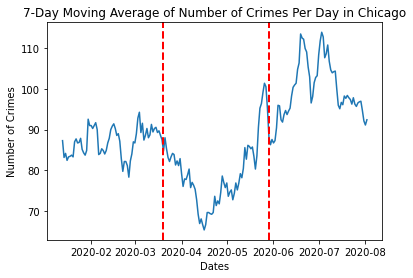

In [68]:
x = prepostct["Dates"]
y = prepostct["7day_ave"]
plt.plot(x,y)
plt.title("7-Day Moving Average of Number of Crimes Per Day in Chicago")
plt.xlabel("Dates")
plt.ylabel("Number of Crimes")
plt.axvline(pd.to_datetime('2020-03-20'), color='r', linestyle='--', lw=2)
plt.axvline(pd.to_datetime('2020-05-29'), color='r', linestyle='--', lw=2);

In [86]:
observed = pd.Series([pre,lock,post], index=["Pre-lockdown", "Lockdown", "Post-Lockdown"])

df = pd.DataFrame([observed]).T
df[1] = (pre + lock + post)/3
df.columns = ["observed", "expected"]
stats.chisquare(df['observed'], df['expected'])

# stats.chisquare(expected, observed)

Power_divergenceResult(statistic=136.9717807330522, pvalue=1.8069899019433304e-30)